# LSTM Network

In [1]:
import os, sys
import datetime

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv1D, MaxPooling1D, MultiHeadAttention, LayerNormalization, Add

# TF optimizations for laptop
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Hide all GPUs from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce verbose logging
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'  # Enable OneDNN optimizations
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce verbose logging
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'  # Enable OneDNN optimizations
tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(2)# Verify CPU-only mode
print("Available devices:", tf.config.list_physical_devices())
print("GPU available:", tf.config.list_physical_devices('GPU'))

LOCAL = True
rootpath = os.path.dirname(os.path.dirname(os.getcwd()))
print(f"rootpath: {rootpath}")
# module_path = os.path.abspath(os.path.join(rootpath, 'src'))
# sys.path.insert(0, module_path)
sys.path.append(os.path.dirname(os.path.abspath('.')))
import data_challenge as data
import models_challenge as models

2025-07-18 16:06:57.436176: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-18 16:06:57.445718: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-18 16:06:57.467919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752847617.515727 4120658 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752847617.531068 4120658 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752847617.568750 4120658 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU available: []
rootpath: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting


2025-07-18 16:07:02.725363: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
if LOCAL:
    dirfpath = data.download_stock_price_prediction_challenge_data(rootpath)
    test_path = os.path.join(dirfpath, "test")
    train_stocks_path = os.path.join(dirfpath, "train", "stocks")
    train_indices_path = os.path.join(dirfpath, "train", "indices")
    
else:
    test_path = "/kaggle/input/stock-price-prediction-challenge/test"
    train_stocks_path = "/kaggle/input/stock-price-prediction-challenge/train/stocks"
    train_indices_path = "/kaggle/input/stock-price-prediction-challenge/train/indices",

paths = {
    'test_path': test_path,
    'train_stocks_path': train_stocks_path,
    'train_indices_path': train_indices_path}

Raw data already found in location /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data/stock-price-prediction-challenge.zip
Raw data already unzipped


## Helper Functions


In [94]:
def build_scalers(X_train, y_train, X_test, y_test):
    Xscaler = MinMaxScaler(feature_range=(0, 1))
    yscaler = MinMaxScaler(feature_range=(-1, 1))
    X_train_scaled = Xscaler.fit_transform(X_train)
    X_test_scaled = Xscaler.transform(X_test)
    y_train_scaled = yscaler.fit_transform(y_train)
    y_test_scaled = yscaler.transform(y_test)
    return Xscaler, yscaler, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled

def make_sequences(X, y, time_steps):
    """
    X: array of shape (N, F)
    y: array of shape (N,) or (N,1)
    returns
      X_seq: (N - time_steps, time_steps, F)
      y_seq: (N - time_steps,   1)   # aligned so y_seq[i] is the label for X_seq[i]
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.stack(Xs), np.stack(ys)


def get_tf_callbacks():
    earlystop_cb = EarlyStopping(
        monitor='val_loss',        # metric to watch
        min_delta=1e-4,            # minimum change to qualify as improvement
        patience=5,                # how many epochs with no improvement before stopping
        verbose=1,                 # prints a message when stopping
        restore_best_weights=True  # at end of training, rolls back to the best weights
    )
    reducelr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,      # reduce LR by this factor
        patience=3,      # after how many bad epochs
        verbose=1
    )
    return earlystop_cb, reducelr_cb
earlystop_cb, reducelr_cb = get_tf_callbacks()

## CNN-LSTM Model

In [ ]:
target = 'Returns'
ticker = 'test_4'
window_size = 10
df = data.get_ticker_df(ticker, test_path, train_stocks_path)
df = data.add_indice_features(df, target, train_indices_path)
df = data.prepare_features(df, target=target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0.5], lags=1, out_len=500)
train_df, test_df = data.split_df(df, train_ratio=0.8)
X_train, y_train = models.get_X_y_multistep(train_df, steps=11, target='Returns')
X_test, y_test = models.get_X_y_multistep(test_df, steps=11, target='Returns')
Xscaler, yscaler, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = build_scalers(X_train, y_train, X_test, y_test)
X_train_scaled_seq, y_train_scaled_seq = make_sequences(X_train_scaled, y_train_scaled, window_size)
X_test_scaled_seq,  y_test_scaled_seq  = make_sequences(X_test_scaled, y_test_scaled, window_size)
print(f'X_train sequence shape: {X_train_scaled_seq.shape}, y_train sequence shape: {y_train_scaled_seq.shape}')
print(f'X_test sequence shape: {X_test_scaled_seq.shape}, y_test sequence shape: {y_test_scaled_seq.shape}')

shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
X_train sequence shape: (380, 10, 16), y_train sequence shape: (380, 11)
X_test sequence shape: (80, 10, 16), y_test sequence shape: (80, 11)


In [5]:
def build_cnn_lstm(params):
    model = Sequential()
    model.add(Input(shape=(params['window_size'], params['num_features'])))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=64))
    model.add(Dense(units=params['num_outputs'])) 
    model.compile(optimizer='adam', loss=params['loss'])
    return model

In [9]:
params = {
    'window_size': window_size,
    'num_features': X_train_scaled_seq.shape[2],
    'num_outputs': y_train_scaled_seq.shape[1],
    'loss': 'mean_squared_error'
}
model = build_cnn_lstm(params)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 8, 32)          │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 4, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 4, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,667 (291.67 KB)

 Trainable params: 74,667 (291.67 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
history = model.fit(
    X_train_scaled_seq,
    y_train_scaled_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled_seq, y_test_scaled_seq),
    verbose=1,
    callbacks=[earlystop_cb, reducelr_cb] # , tensorboard_cb
    )

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - loss: 0.2348 - val_loss: 0.0538 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0592 - val_loss: 0.0280 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0376 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0325 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0294 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0243 - val_loss: 0.0131 - learning_rate: 0.0010
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0253 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0279 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0237 - val_loss: 0.0129 - learning_rate: 0.0010
Epoch 10

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Train RMSE: 0.03517
Test RMSE: 0.02711


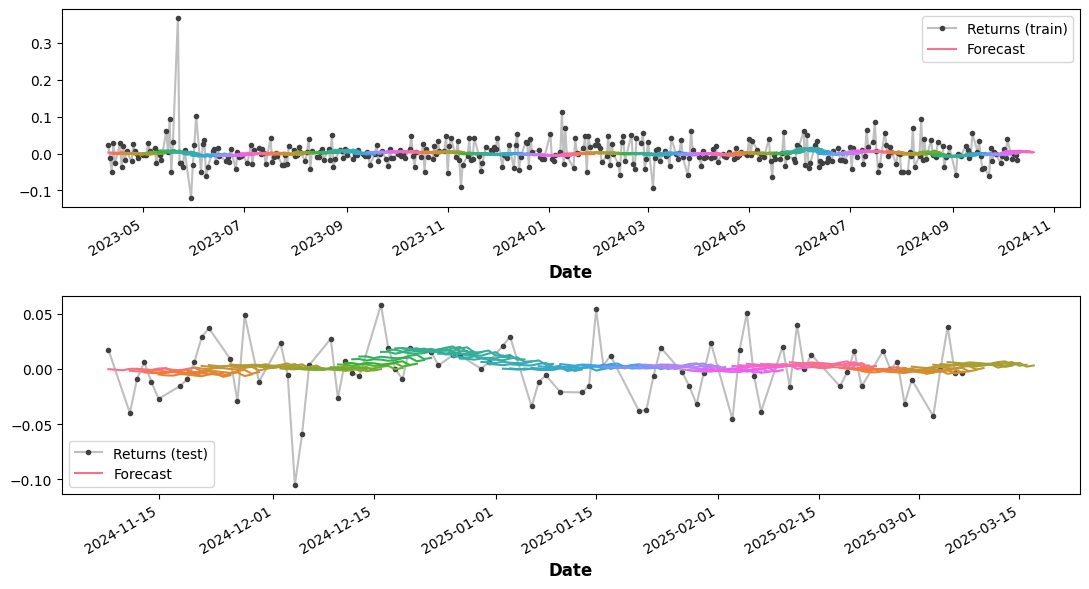

In [81]:
# train performance
y_hat_train_scaled = model.predict(X_train_scaled_seq)
y_hat_train = yscaler.inverse_transform(y_hat_train_scaled)
y_hat_train = pd.DataFrame(y_hat_train, columns=y_train.columns, index=y_train.index[window_size:])
# test prediction
y_hat_test_scaled = model.predict(X_test_scaled_seq)
y_hat_test= yscaler.inverse_transform(y_hat_test_scaled)
y_hat_test = pd.DataFrame(y_hat_test, columns=y_test.columns, index=y_test.index[window_size:])
models.evaluate_multistep(y_train[window_size:], y_hat_train, y_test[window_size:], y_hat_test, df, target)

## LSTM-Attention Model

In [ ]:
target = 'Returns'
ticker = 'test_4'
window_size = 10
df = data.get_ticker_df(ticker, test_path, train_stocks_path)
df = data.add_indice_features(df, target, train_indices_path)
df = data.prepare_features(df, target=target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0.5], lags=1, out_len=500)
train_df, test_df = data.split_df(df, train_ratio=0.8)
X_train, y_train = models.get_X_y_multistep(train_df, steps=11, target='Returns')
X_test, y_test = models.get_X_y_multistep(test_df, steps=11, target='Returns')
Xscaler, yscaler, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = build_scalers(X_train, y_train, X_test, y_test)
X_train_scaled_seq, y_train_scaled_seq = make_sequences(X_train_scaled, y_train_scaled, window_size)
X_test_scaled_seq,  y_test_scaled_seq  = make_sequences(X_test_scaled, y_test_scaled, window_size)
print(f'X_train sequence shape: {X_train_scaled_seq.shape}, y_train sequence shape: {y_train_scaled_seq.shape}')
print(f'X_test sequence shape: {X_test_scaled_seq.shape}, y_test sequence shape: {y_test_scaled_seq.shape}')

shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)


In [3]:
def build_lstm_attention(params):
    # hyperparams
    units_lstm = 50
    drop_lstm = 0.2
    drop_attn = 0.1
    num_heads = 4
    key_dim = 16
    # dense_units = 32
    # drop_dense = 0.2

    # Inputs
    inputs = Input(shape=(params['window_size'], params['num_features']), name="inputs")

    # First LSTM layer (return_sequences for attention)
    x = LSTM(units_lstm, return_sequences=True, name="lstm_1")(inputs)
    x = Dropout(drop_lstm, name="drop_lstm_1")(x)

    # Self‐Attention block
    attn = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        name="multihead_attn"
    )(x, x)
    attn = Dropout(drop_attn, name="drop_attn")(attn)

    # Residual + LayerNorm
    x = Add(name="residual_add")([x, attn])
    x = LayerNormalization(name="layer_norm")(x)

    # Second LSTM (no need to return sequences)
    x = LSTM(units_lstm, return_sequences=False, name="lstm_2")(x)
    x = Dropout(drop_lstm, name="drop_lstm_2")(x)
    
    # Extra Dense hidden layer
    # x = Dense(dense_units, activation='relu', name="dense_hidden")(x)
    # x = Dropout(drop_dense, name="drop_dense")(x)
    
    # Final output
    outputs = Dense(params['num_outputs'] , activation='linear', name="predictions")(x)

    model = Model(inputs, outputs, name="LSTM_with_Attention")
    model.compile(optimizer='adam', loss=params['loss'])
    return model

In [98]:
params = {
    'window_size': window_size,
    'num_features': X_train_scaled_seq.shape[2],
    'num_outputs': y_train_scaled_seq.shape[1],
    'loss': 'mean_squared_error'
}
model = build_lstm_attention(params)
model.summary()

Model: "LSTM_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 10, 16)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 10, 50)    │     13,400 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_lstm_1         │ (None, 10, 50)    │          0 │ lstm_1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attn      │ (None, 10, 50)    │     13,042 │ drop_lstm_1[0][0… │
│ (MultiHeadAttentio… │                   │            │ drop_lstm_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_attn (Dropout) │ (None, 10, 50)    │          0 │ multihead_attn[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_add (Add)  │ (None, 10, 50)    │          0 │ drop_lstm_1[0][0… │
│                     │                   │            │ drop_attn[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm          │ (None, 10, 50)    │        100 │ residual_add[0][… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 50)        │     20,200 │ layer_norm[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_lstm_2         │ (None, 50)        │          0 │ lstm_2[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 11)        │        561 │ drop_lstm_2[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,303 (184.78 KB)

 Trainable params: 47,303 (184.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train_scaled_seq,
    y_train_scaled_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled_seq, y_test_scaled_seq),
    verbose=1,
    callbacks=[earlystop_cb, reducelr_cb] # , tensorboard_cb
    )

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.2098 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0604 - val_loss: 0.0160 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0462 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0432 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0373 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0382 - val_loss: 0.0131 - learning_rate: 0.0010
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0349 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0334 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0323
Epoch 9: ReduceLROnPlateau reducing learning rate t

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Train RMSE: 0.03565
Test RMSE: 0.02790


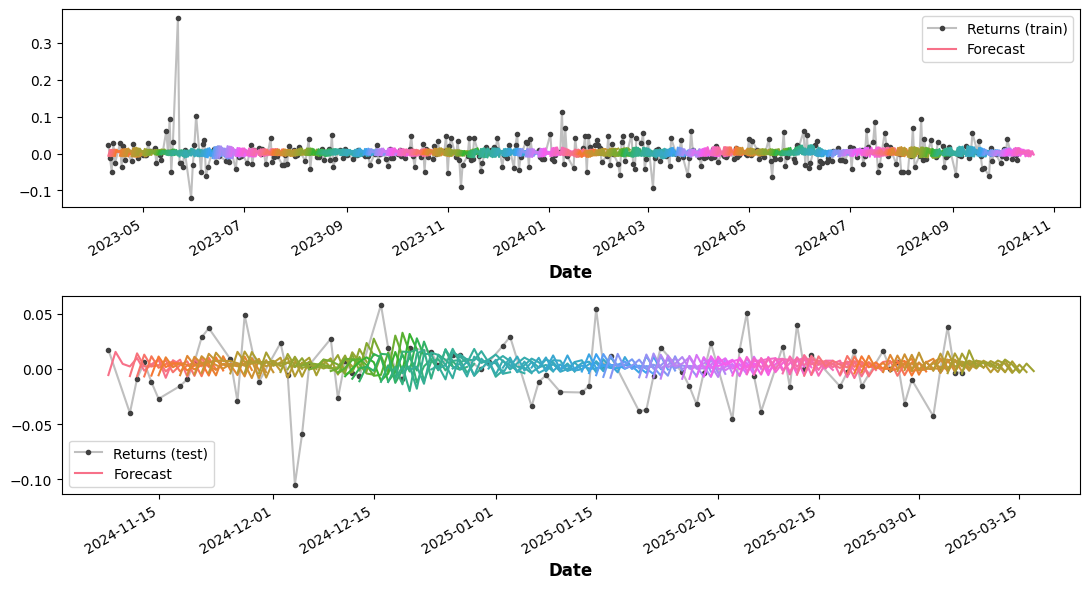

In [100]:
# train performance
y_hat_train_scaled = model.predict(X_train_scaled_seq)
y_hat_train = yscaler.inverse_transform(y_hat_train_scaled)
y_hat_train = pd.DataFrame(y_hat_train, columns=y_train.columns, index=y_train.index[window_size:])
# test prediction
y_hat_test_scaled = model.predict(X_test_scaled_seq)
y_hat_test= yscaler.inverse_transform(y_hat_test_scaled)
y_hat_test = pd.DataFrame(y_hat_test, columns=y_test.columns, index=y_test.index[window_size:])
models.evaluate_multistep(y_train[window_size:], y_hat_train, y_test[window_size:], y_hat_test, df, target)

## CNN-LSTM-Attention Model

In [106]:
target = 'Returns'
ticker = 'test_4'
window_size = 10
forecast_horizon = 11
df = data.get_ticker_df(ticker, test_path, train_stocks_path)
df = data.add_indice_features(df, target, train_indices_path)
df = data.prepare_features(df, target=target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0.5], lags=1, out_len=500)
train_df, test_df = data.split_df(df, train_ratio=0.8)
X_train, y_train = models.get_X_y_multistep(train_df, steps=forecast_horizon, target='Returns')
X_test, y_test = models.get_X_y_multistep(test_df, steps=forecast_horizon, target='Returns')
Xscaler, yscaler, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = build_scalers(X_train, y_train, X_test, y_test)
X_train_scaled_seq, y_train_scaled_seq = make_sequences(X_train_scaled, y_train_scaled, window_size)
X_test_scaled_seq,  y_test_scaled_seq  = make_sequences(X_test_scaled, y_test_scaled, window_size)
print(f'X_train sequence shape: {X_train_scaled_seq.shape}, y_train sequence shape: {y_train_scaled_seq.shape}')
print(f'X_test sequence shape: {X_test_scaled_seq.shape}, y_test sequence shape: {y_test_scaled_seq.shape}')

shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
X_train sequence shape: (380, 10, 16), y_train sequence shape: (380, 11)
X_test sequence shape: (80, 10, 16), y_test sequence shape: (80, 11)


In [102]:
def build_cnn_lstm_attention(params):
    # hyperparams
    conv_filters = 32
    conv_kernel = 3
    pool_size = 2
    units_lstm = 50
    drop_lstm = 0.2
    drop_attn = 0.1
    num_heads = 4
    key_dim = 16
    dense_units = 32
    drop_dense = 0.2

    # Inputs
    inputs = Input(shape=(params['window_size'], params['num_features']), name="inputs")

    x = Conv1D(conv_filters, conv_kernel, activation='relu', padding='causal', name="conv1d")(inputs)
    x = MaxPooling1D(pool_size, name="maxpool")(x)

    # First LSTM layer (return_sequences for attention)
    x = LSTM(units_lstm, return_sequences=True, name="lstm_1")(x)
    x = Dropout(drop_lstm, name="drop_lstm_1")(x)

    # Multihead Self‐Attention + Residual & LayerNorm
    attn = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        name="multihead_attn"
    )(x, x)
    attn = Dropout(drop_attn, name="drop_attn")(attn)
    x = Add(name="residual_add")([x, attn])
    x = LayerNormalization(name="layer_norm")(x)

    # Second LSTM (no need to return sequences)
    x = LSTM(units_lstm, return_sequences=False, name="lstm_2")(x)
    x = Dropout(drop_lstm, name="drop_lstm_2")(x)

    # Extra Dense hidden layer
    x = Dense(dense_units, activation='relu', name="dense_hidden")(x)
    x = Dropout(drop_dense, name="drop_dense")(x)

    # Final output
    outputs = Dense(params['num_outputs'] , activation='linear', name="predictions")(x)

    model = Model(inputs, outputs, name="LSTM_with_Attention")
    model.compile(optimizer='adam', loss=params['loss'])
    return model

In [103]:
params = {
    'window_size': window_size,
    'num_features': X_train_scaled_seq.shape[2],
    'num_outputs': y_train_scaled_seq.shape[1],
    'loss': 'mean_squared_error'
}
model = build_cnn_lstm_attention(params)
model.summary()

Model: "LSTM_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 10, 16)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 32)    │      1,568 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool             │ (None, 5, 32)     │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 5, 50)     │     16,600 │ maxpool[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_lstm_1         │ (None, 5, 50)     │          0 │ lstm_1[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attn      │ (None, 5, 50)     │     13,042 │ drop_lstm_1[0][0… │
│ (MultiHeadAttentio… │                   │            │ drop_lstm_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_attn (Dropout) │ (None, 5, 50)     │          0 │ multihead_attn[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ residual_add (Add)  │ (None, 5, 50)     │          0 │ drop_lstm_1[0][0… │
│                     │                   │            │ drop_attn[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm          │ (None, 5, 50)     │        100 │ residual_add[0][… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 50)        │     20,200 │ layer_norm[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_lstm_2         │ (None, 50)        │          0 │ lstm_2[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_hidden        │ (None, 32)        │      1,632 │ drop_lstm_2[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_dense          │ (None, 32)        │          0 │ dense_hidden[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ predictions (Dense) │ (None, 11)        │        363 │ drop_dense[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,505 (209.00 KB)

 Trainable params: 53,505 (209.00 KB)

 Non-trainable params: 0 (0.00 B)

In [104]:
history = model.fit(
    X_train_scaled_seq,
    y_train_scaled_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled_seq, y_test_scaled_seq),
    verbose=1,
    callbacks=[earlystop_cb, reducelr_cb] # , tensorboard_cb
    )

Epoch 1/100


12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - loss: 0.2170 - val_loss: 0.0374 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0984 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0770 - val_loss: 0.0209 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0702 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0667 - val_loss: 0.0190 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0585 - val_loss: 0.0201 - learning_rate: 0.0010
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0528 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0516 - val_loss: 0.0170 - learning_rate: 0.0010
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0482 - val_loss: 0.0173 - learning_rate: 0.0010
Epoch 10/100
12/12 ━

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Train RMSE: 0.03536
Test RMSE: 0.02768


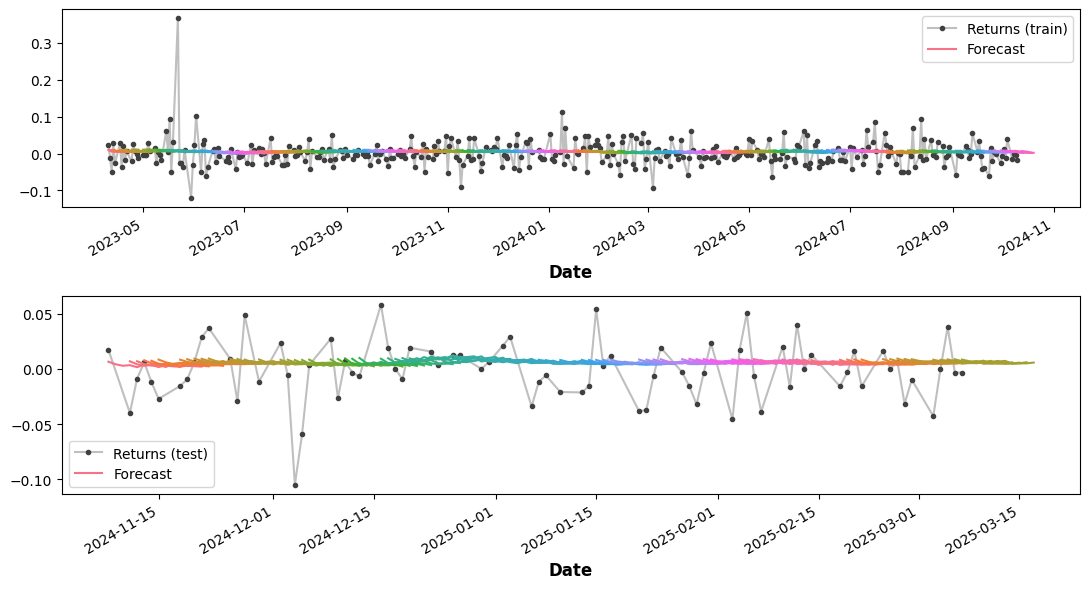

In [105]:
# train performance
y_hat_train_scaled = model.predict(X_train_scaled_seq)
y_hat_train = yscaler.inverse_transform(y_hat_train_scaled)
y_hat_train = pd.DataFrame(y_hat_train, columns=y_train.columns, index=y_train.index[window_size:])
# test prediction
y_hat_test_scaled = model.predict(X_test_scaled_seq)
y_hat_test= yscaler.inverse_transform(y_hat_test_scaled)
y_hat_test = pd.DataFrame(y_hat_test, columns=y_test.columns, index=y_test.index[window_size:])
models.evaluate_multistep(y_train[window_size:], y_hat_train, y_test[window_size:], y_hat_test, df, target)

## Forecasting and submission

In [3]:
target = 'Returns'
ticker = 'test_4'
window_size = 10
forecast_horizon = 11
df = data.get_ticker_df(ticker, test_path, train_stocks_path)
df = data.add_indice_features(df, target, train_indices_path)
df = data.prepare_features(df, target=target, beta_window=10, ma_windows=[10, 20, 60], ewm_alpha=[0.1, 0.3, 0.5], lags=1, out_len=500)
train_df, test_df = data.split_df(df, train_ratio=0.8)
X_train, y_train = models.get_X_y_multistep(train_df, steps=forecast_horizon, target='Returns')
X_test, y_test = models.get_X_y_multistep(test_df, steps=forecast_horizon, target='Returns')
Xscaler, yscaler, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = models.build_scalers(X_train, y_train, X_test, y_test)
X_train_scaled_seq, y_train_scaled_seq = models.make_sequences(X_train_scaled, y_train_scaled, window_size)
X_test_scaled_seq,  y_test_scaled_seq  = models.make_sequences(X_test_scaled, y_test_scaled, window_size)
print(f'X_train sequence shape: {X_train_scaled_seq.shape}, y_train sequence shape: {y_train_scaled_seq.shape}')
print(f'X_test sequence shape: {X_test_scaled_seq.shape}, y_test sequence shape: {y_test_scaled_seq.shape}')

shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)
X_train sequence shape: (380, 10, 16), y_train sequence shape: (380, 11)
X_test sequence shape: (80, 10, 16), y_test sequence shape: (80, 11)


In [6]:
params = {
    'window_size': window_size,
    'num_features': X_train_scaled_seq.shape[2],
    'num_outputs': y_train_scaled_seq.shape[1],
    'loss': 'mean_squared_error'
}
tickers = ['test_1', 'test_2', 'test_3', 'test_4', 'test_5']
forecasts = models.run_forecasts(
    model_builder=build_cnn_lstm,
    params=params,
    tickers=tickers,
    paths=paths
    )

Training and Forecasting for: test_1
shape of final df: (500, 17)
Train shape: (400, 17), Test shape: (100, 17)
X shape: (390, 16), y_multi shape: (390, 11)
X shape: (90, 16), y_multi shape: (90, 11)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - loss: 0.0853 - val_loss: 0.0222 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0316 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0273 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0225 - val_loss: 0.0149 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0224 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0253 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 7/100
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0234
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0231 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0209 - val_loss: 0.0148 - learning_

In [7]:
models.create_submission_file(forecasts, rootpath, tickers, fnamesuffix='_CNN-LSTM')

Submission file created: Regression_submission_CNN-LSTM_2025-07-18_16-11-15.csv
